# Aligning NIRSpec MOS Spectra using Spectral Features

In this notebook, we will demonstrate how to align two NIRSpec MOS spectra using spectral features. This process can be used to check WCS solutions, or to fine-tune the spectral registration.

In [43]:
%matplotlib notebook

from astropy.io import fits
from astropy.modeling import models, fitting
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

For this demonstration, we'll use some sample data which has been run partway through the pipeline, ending with extract2d. This means that the spectra have not been rectified. If you use data which has already been extracted as 1D spectra, you can skip the next few steps.

In [33]:
filename = 'F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_cal.fits'
fits.info(filename) #What extensions should we use?

Filename: F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   ()      
  1  SCI           1 ImageHDU        70   (91, 18)   float32   
  2  DQ            1 ImageHDU        26   (91, 18)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU        23   (91, 18)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (91, 18)   float32   
  5  BARSHADOW     1 ImageHDU         9   (91, 18)   float32   
  6  RELSENS       1 BinTableHDU     15   101R x 2C   [D, D]   
  7  VAR_POISSON    1 ImageHDU         9   (91, 18)   float32   
  8  VAR_RNOISE    1 ImageHDU         9   (91, 18)   float32   
  9  SCI           2 ImageHDU        68   (282, 15)   float32   
 10  DQ            2 ImageHDU        11   (282, 15)   int32 (rescales to uint32)   
 11  ERR           2 ImageHDU        10   (282, 15)   float32   
 12  WAVELENGTH    2 ImageHDU         9   (282, 15)   float

<IPython.core.display.Javascript object>


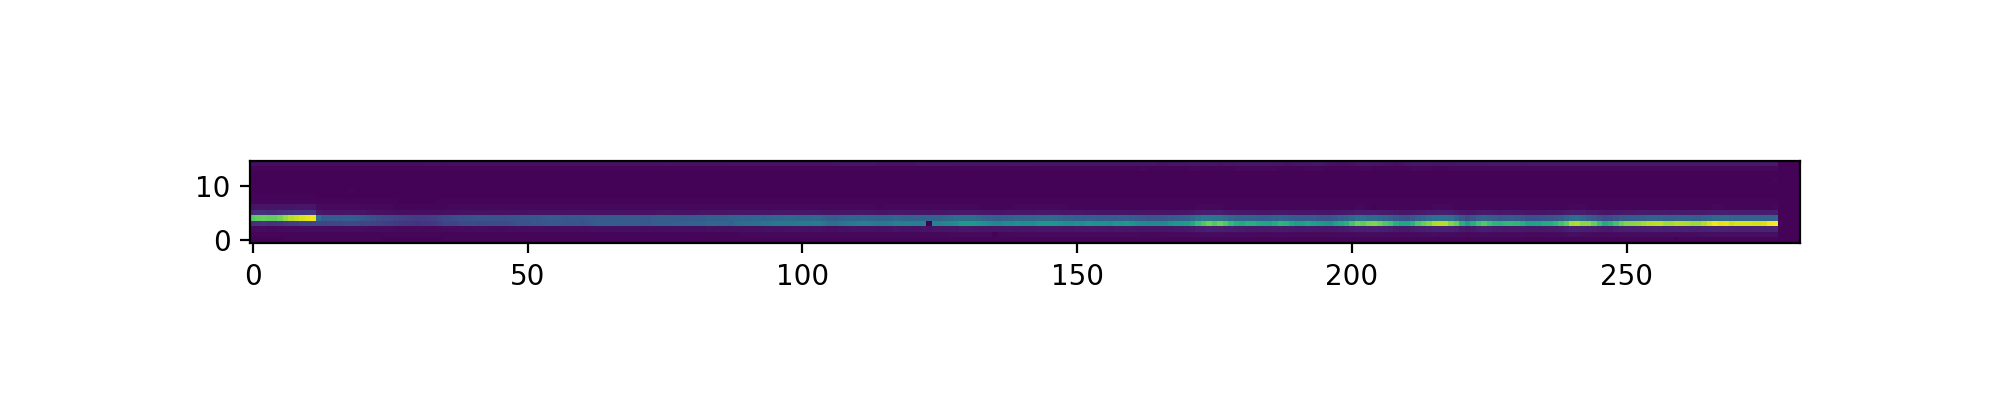

<IPython.core.display.Javascript object>


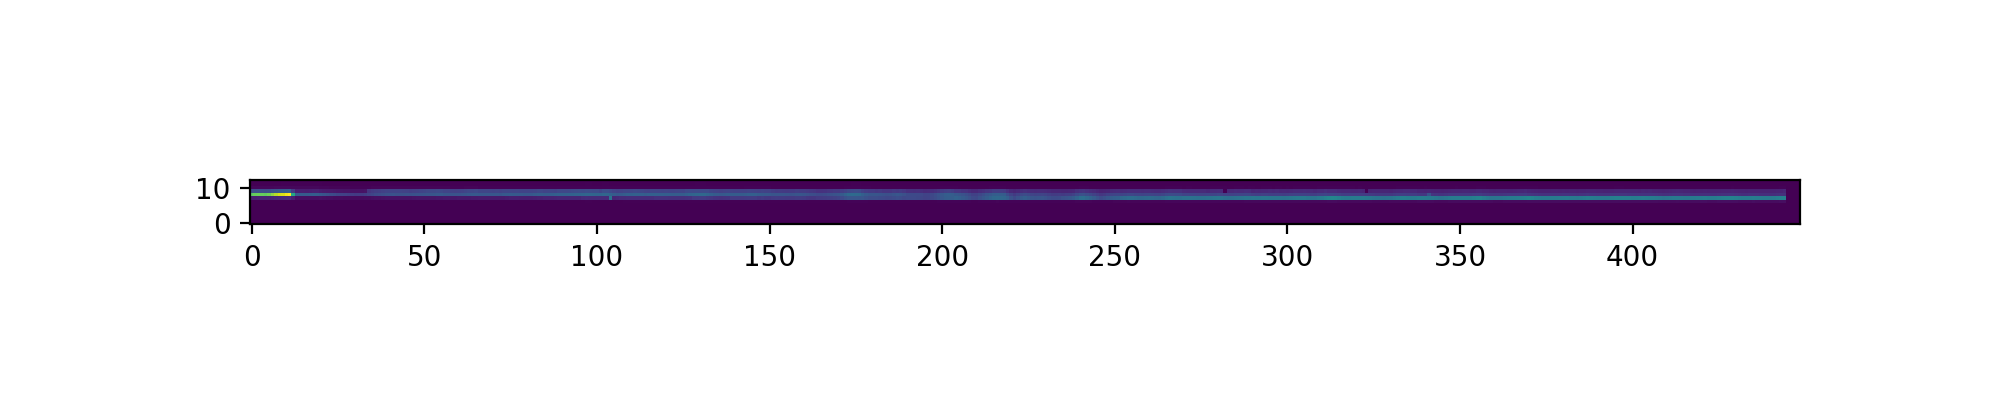

In [34]:
#These are two science extensions with sufficient pixels
ext1 = 9
ext2 = 23

sci1 = fits.getdata(filename, ext1)
sci2 = fits.getdata(filename, ext2)

fig1, ax1 = plt.subplots(figsize=(10,2))
tmp = ax1.imshow(sci1, origin='lower', interpolation='none')
fig2, ax2 = plt.subplots(figsize=(10,2))
tmp = ax2.imshow(sci2, origin='lower', interpolation='none')

<IPython.core.display.Javascript object>


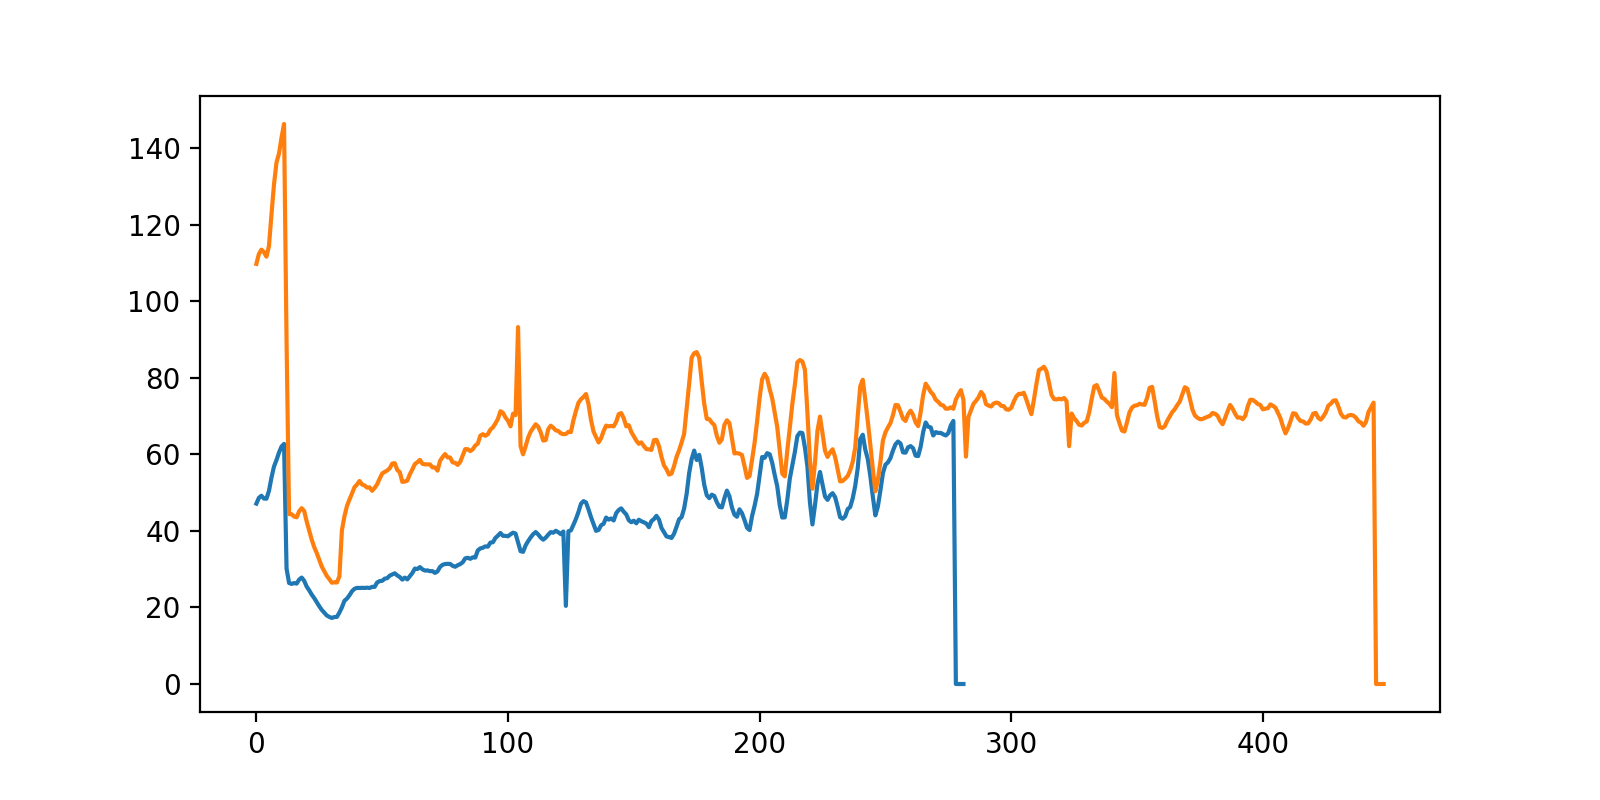

In [35]:
#We'll pretend that these are already rectified, and do a simple sum over the cross-dispersion 
#direction to work with 1d spectra
spec1 = sci1.sum(axis=0)
spec2 = sci2.sum(axis=0)
fig3 = plt.figure(figsize=(8, 4))
tmp = plt.plot(spec1)
tmp = plt.plot(spec2)

<IPython.core.display.Javascript object>


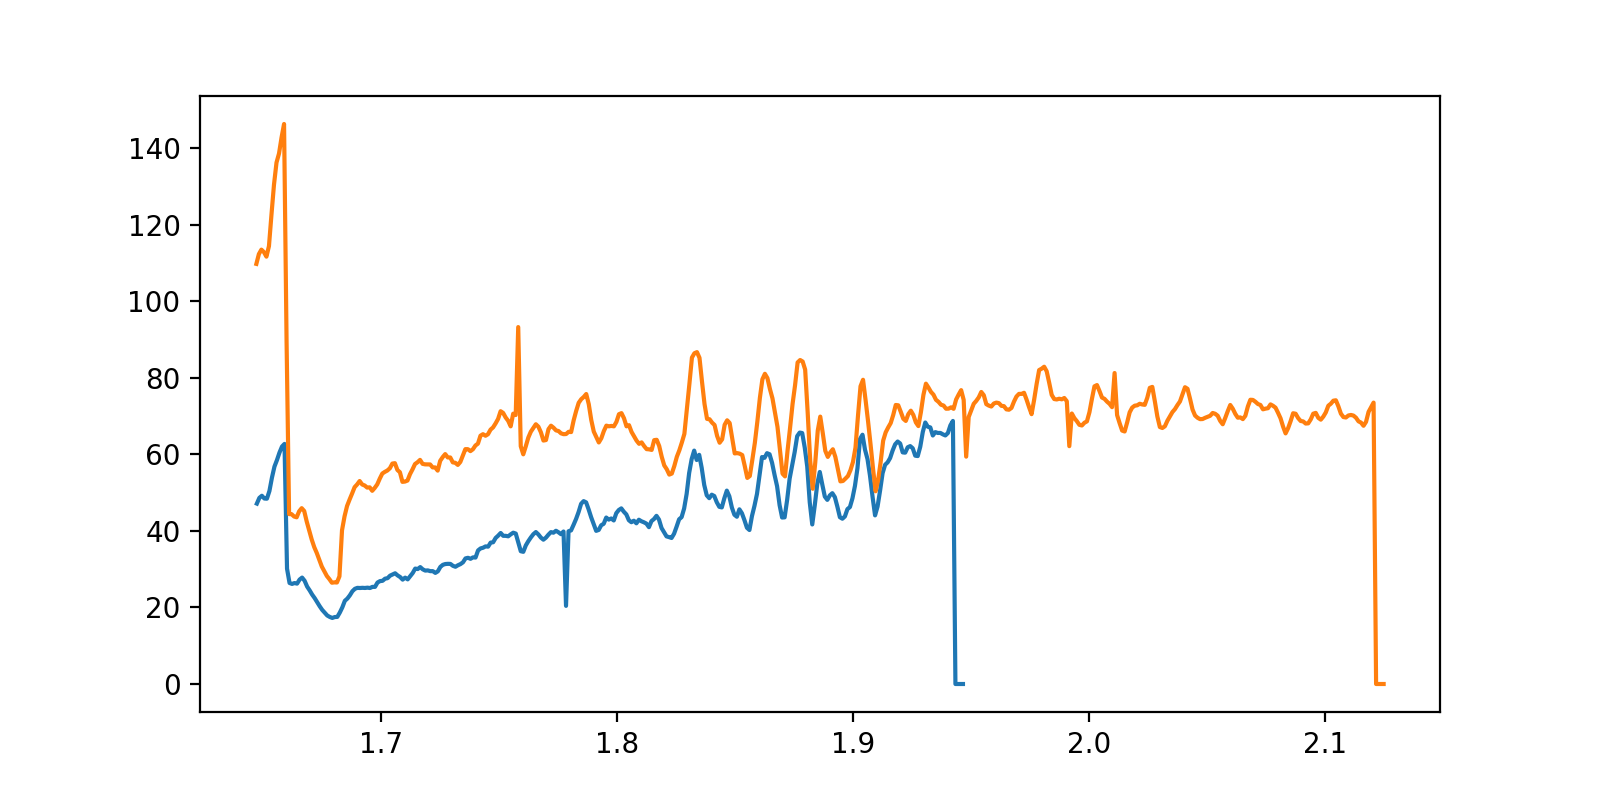

In [36]:
#The wavelength extensions are also 2D, so we'll use a median (ignoring NaN values) to get 1-D wavelength arrays
wav1 = fits.getdata(filename, ext1+3)
wav2 = fits.getdata(filename, ext2+3)

wave1 = np.nanmedian(wav1, axis=0)
wave2 = np.nanmedian(wav2, axis=0)

fig4 = plt.figure(figsize=(8, 4))
tmp = plt.plot(wave1, spec1)
tmp = plt.plot(wave2, spec2)

<IPython.core.display.Javascript object>


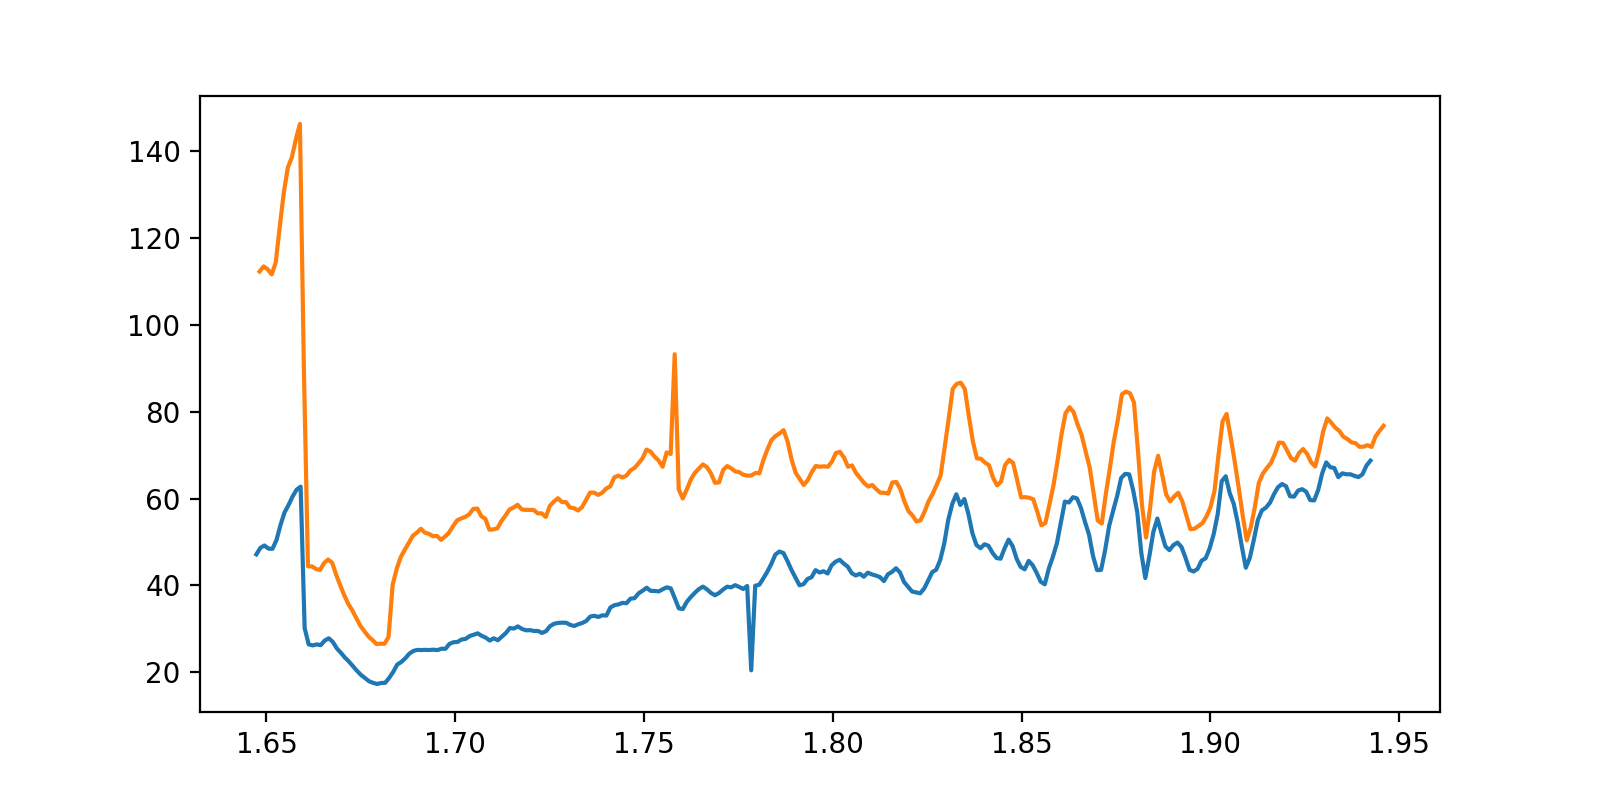

In [38]:
#Since the spectra are different shapes, we need to isolate the portions of the spectra where they overlap
wave_lo, wave_hi = max(wave1.min(), wave2.min()), min(wave1.max(), wave2.max())
in_wave1 = (wave1 >= wave_lo) & (wave1 <= wave_hi) & (spec1 != 0.0)
in_wave2 = (wave2 >= wave_lo) & (wave2 <= wave_hi) & (spec2 != 0.0)

fig5 = plt.figure(figsize=(8, 4))
tmp = plt.plot(wave1[in_wave1], spec1[in_wave1])
tmp = plt.plot(wave2[in_wave2], spec2[in_wave2])

<IPython.core.display.Javascript object>


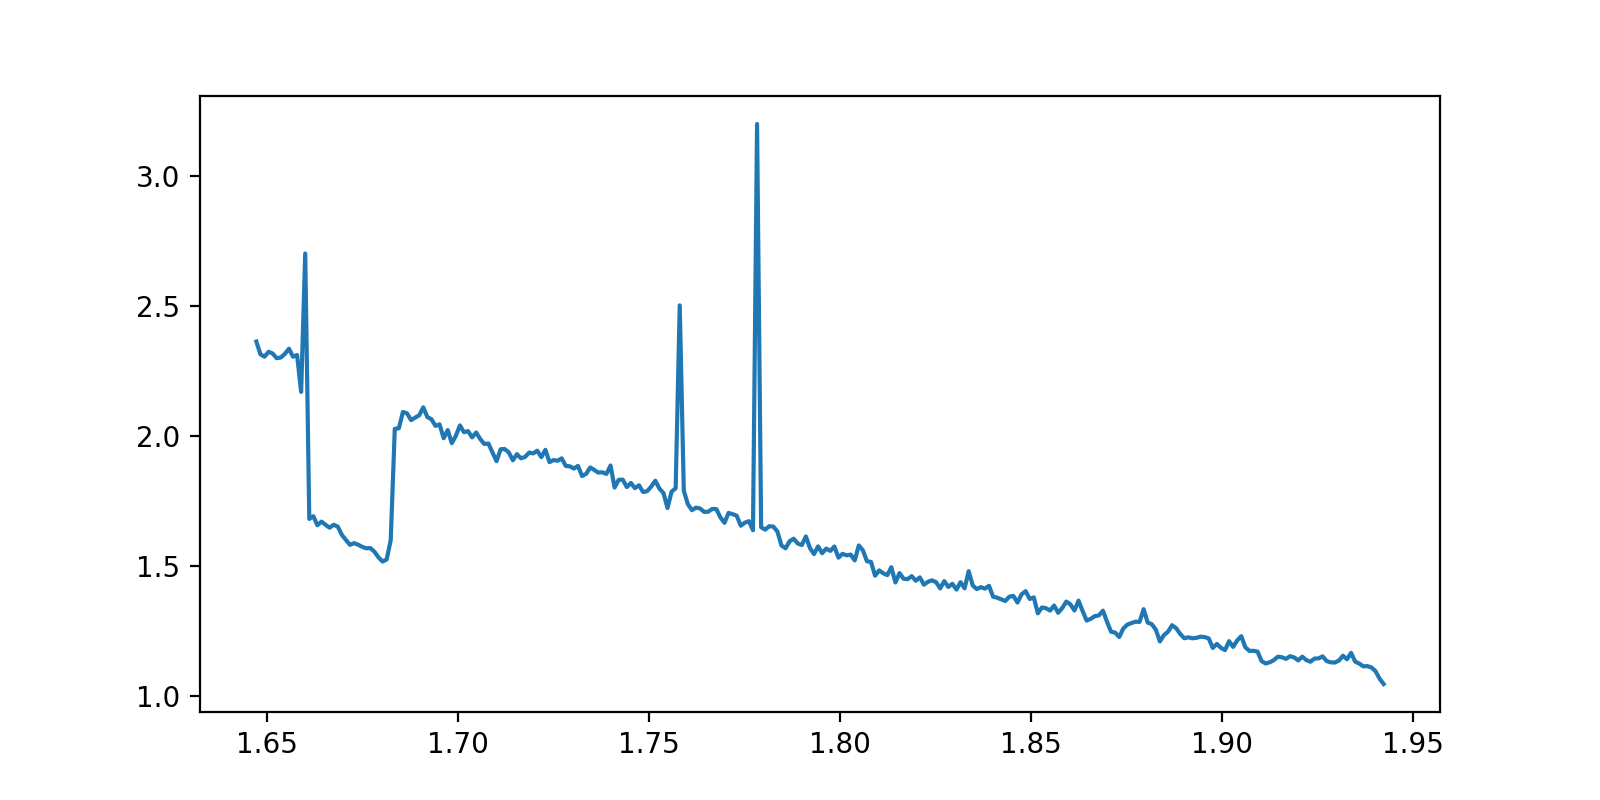

In [40]:
#We also need to normalize the fluxes to make our wavelength fits better. First, plot the scale factor
out_wave = wave1[in_wave1]
interp_spec2 = interp1d(wave2[in_wave2], spec2[in_wave2], fill_value='extrapolate')(out_wave)
div_spec = interp_spec2 / spec1[in_wave1]

fig6 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, div_spec)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                  c1                 c2       
    ------------------ ------------------- -----------------
    26.541825182923606 -23.538645732531762 5.369952771483565


<IPython.core.display.Javascript object>


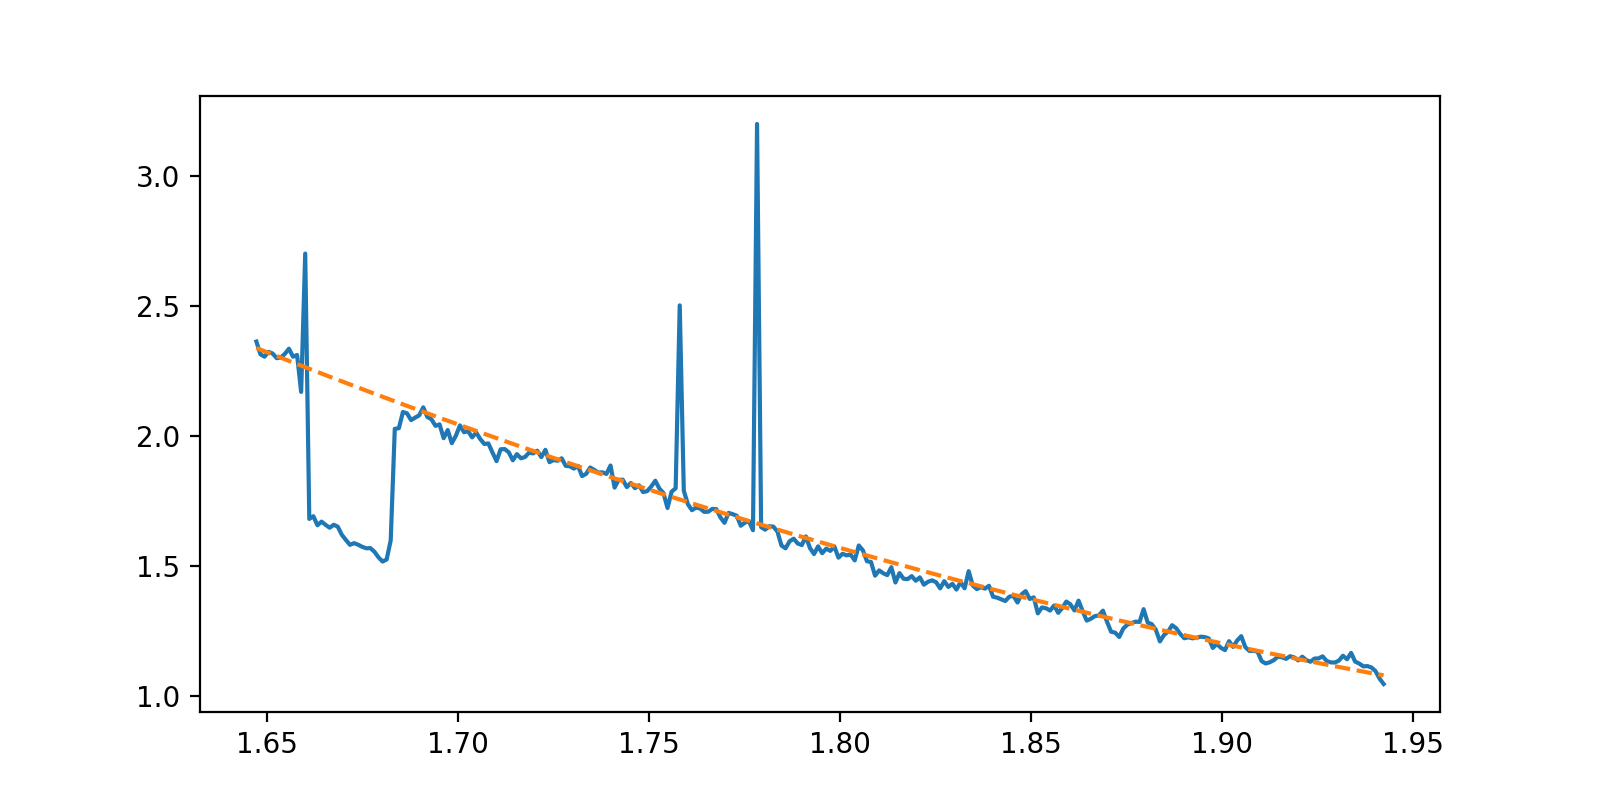

<IPython.core.display.Javascript object>


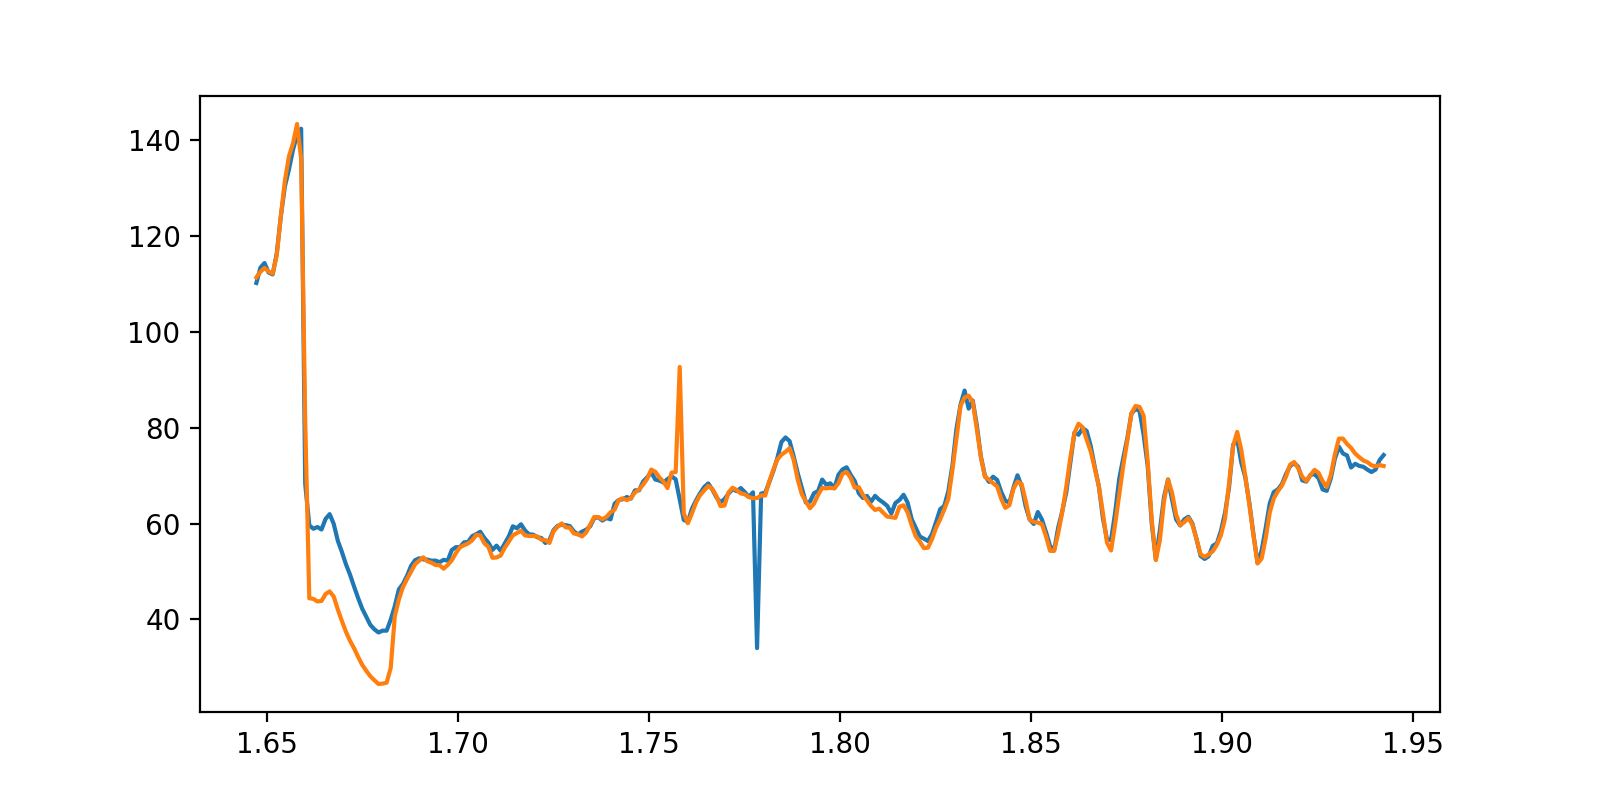

In [44]:
# It seems that a 2nd-order polynomial, starting redwards of 1.70 microns, will be a good fit
# If the spectra are not already well-aligned, more robust fitting methods, probably including
# outlier rejection, would be necessary.
norm_model = models.Polynomial1D(2)
fitter = fitting.LinearLSQFitter()

ok_px = (np.isfinite(div_spec)) & (out_wave >= 1.70)

normalization = fitter(norm_model, out_wave[ok_px], div_spec[ok_px])
print(normalization)

flux_scale_factor = normalization(out_wave)
scaled_spec1 = spec1[in_wave1] * flux_scale_factor

fig7 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, div_spec)
tmp = plt.plot(out_wave, flux_scale_factor, '--')


fig8 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, scaled_spec1)
tmp = plt.plot(out_wave, interp_spec2)

In [45]:
# Now we'll perform the wavelength fitting. We do this using scipy.optimize.minimize, where 
# we'll transform one of the wavelength arrays with a polynomial, then use that new wavelength
# to resample the associated spectrum to the reference wavelengths. Our metric is the standard
# deviation of the difference spectrum, which we want to minimize.

def alter_wave(poly_coefs, old_wave): #helper function for plotting purposes
    altered_wave2 = np.zeros_like(old_wave)
    for c, coef in enumerate(poly_coefs): #this can be something other than a polynomial, if desired
        altered_wave2 += coef * old_wave**c
    return altered_wave2

def alter_spec(wave): #helper function for plotting purposes
    altered_spec2 = interp1d(wave, spec2[in_wave2], fill_value='extrapolate')(out_wave)
    return altered_spec2

def fit_metric(poly_coefs, old_wave):
    altered_wave2 = alter_wave(poly_coefs, old_wave) #construct the new wavelength array
    altered_spec2 = alter_spec(altered_wave2) #resample the spectrum
    diff_spec = altered_spec2 - scaled_spec1 #difference spectrum
    return diff_spec.std() #this is what we are minimizing

#Try a 2nd-degree polynomial to start; the coefficient array can be any size, depending on what degree polynomial
#you wish to fit.
pixel_fit = minimize(fit_metric, np.array([0., 1., 0.]), args=(wave2[in_wave2],), method='Nelder-Mead')

In [46]:
#The fit did indeed find a result very close to the expected [0, 1, 0]
print(fit_metric(pixel_fit.x, wave2[in_wave2]))
print(pixel_fit)

4.464236232264969
 final_simplex: (array([[ 2.22941256e-04,  1.00062731e+00, -4.90714892e-04],
       [ 2.20088340e-04,  1.00065048e+00, -5.05563808e-04],
       [ 2.27946099e-04,  1.00068442e+00, -5.27082798e-04],
       [ 2.20789710e-04,  1.00065963e+00, -5.08723762e-04]]), array([4.46423623, 4.46423914, 4.46425924, 4.46429781]))
           fun: 4.464236232264969
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 38
        status: 0
       success: True
             x: array([ 2.22941256e-04,  1.00062731e+00, -4.90714892e-04])


<IPython.core.display.Javascript object>


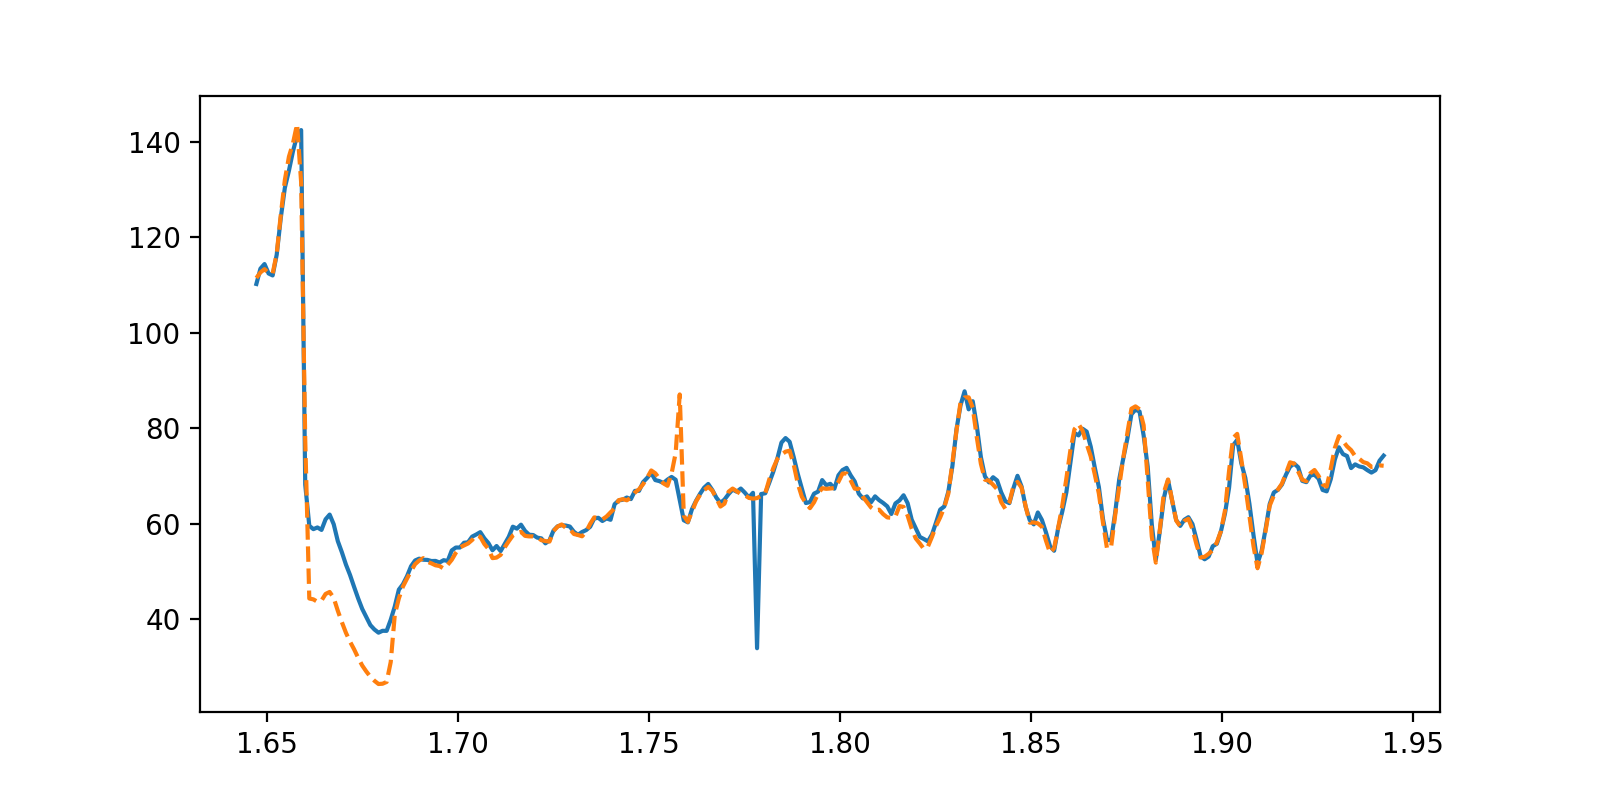

<IPython.core.display.Javascript object>


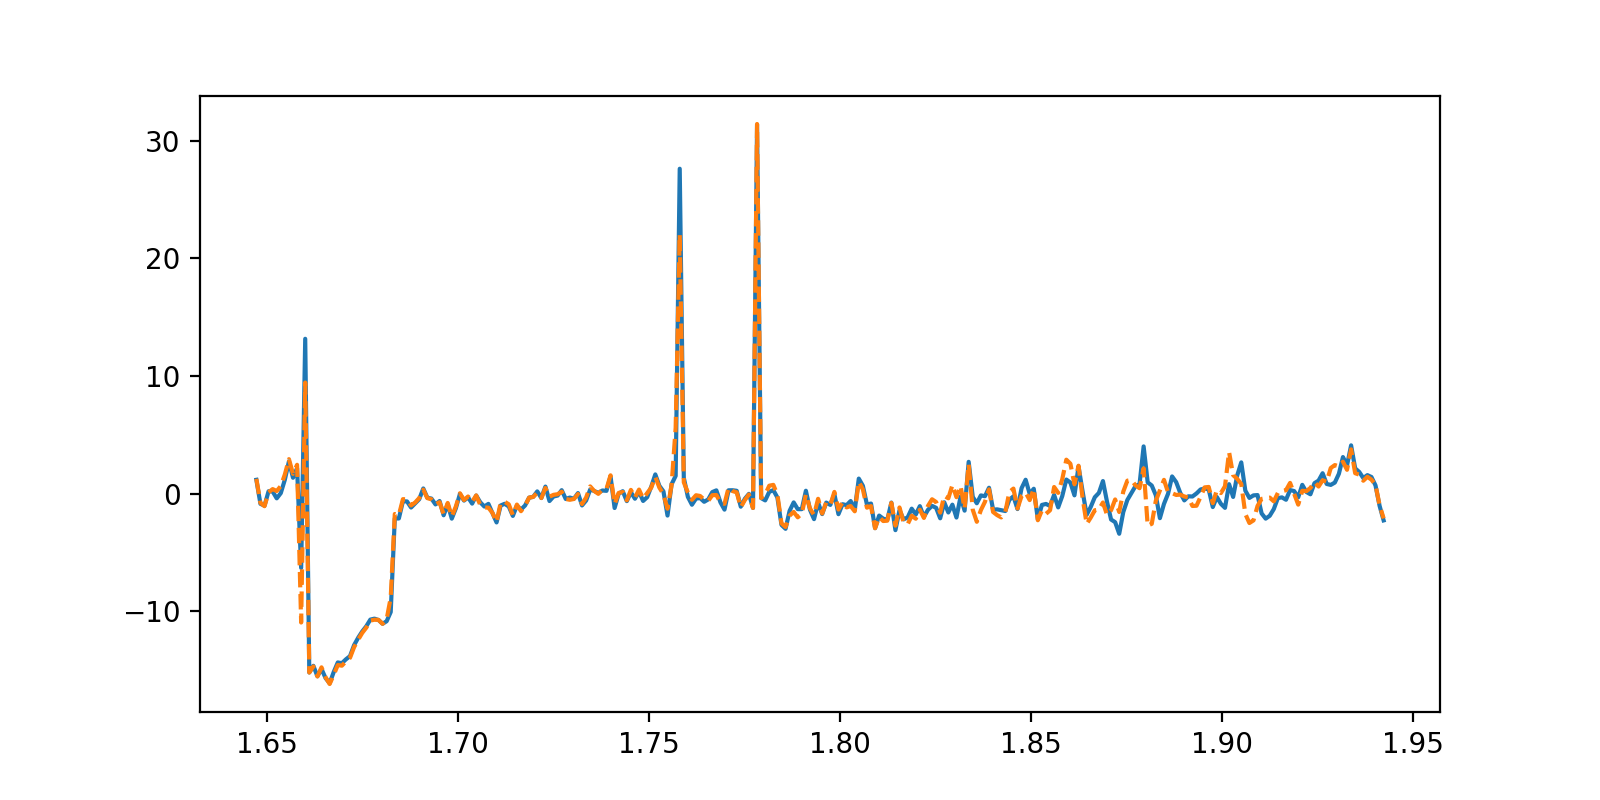

<IPython.core.display.Javascript object>


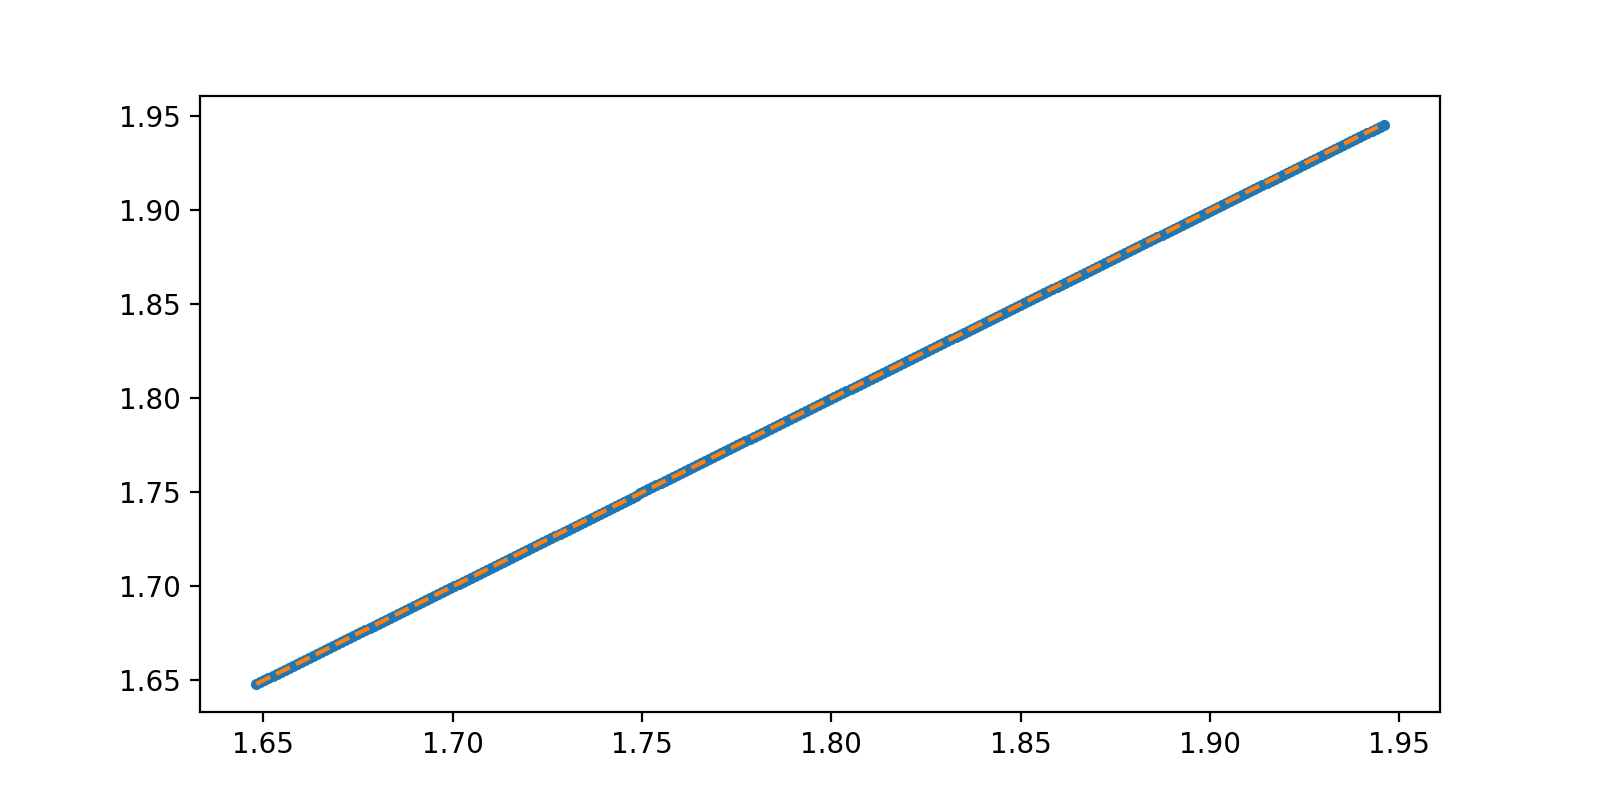

In [47]:
#How did we do?
alt_wave2 = alter_wave(pixel_fit.x, wave2[in_wave2])
alt_spec2 = alter_spec(alt_wave2)

fig9 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, scaled_spec1)
tmp = plt.plot(out_wave, alt_spec2, '--')

fig10 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, interp_spec2 - scaled_spec1)
tmp = plt.plot(out_wave, alt_spec2 - scaled_spec1, '--')

fig11 = plt.figure(figsize=(8,4))
tmp = plt.plot(wave2[in_wave2], alt_wave2, '.')
tmp = plt.plot(wave2[in_wave2], wave2[in_wave2], '--')

In [28]:
#Now we'll try it with a bad wavelength array. We'll scale the wavelength array by 10% and try again
bad_wave2 = wave2[in_wave2] * 1.1

pixel_fit2 = minimize(fit_metric, np.array([0., 1.0, 0.]), args=(bad_wave2,), method='Nelder-Mead')
print(pixel_fit2)

 final_simplex: (array([[2.19464048e-04, 9.08705509e-01, 1.21618578e-04],
       [2.19658701e-04, 9.08702964e-01, 1.22092766e-04],
       [2.19587640e-04, 9.08706869e-01, 1.21922365e-04],
       [2.19888565e-04, 9.08709066e-01, 1.22503995e-04]]), array([10.13716981, 10.13717109, 10.13717227, 10.13725978]))
           fun: 10.137169810353658
       message: 'Optimization terminated successfully.'
          nfev: 82
           nit: 41
        status: 0
       success: True
             x: array([2.19464048e-04, 9.08705509e-01, 1.21618578e-04])


<IPython.core.display.Javascript object>


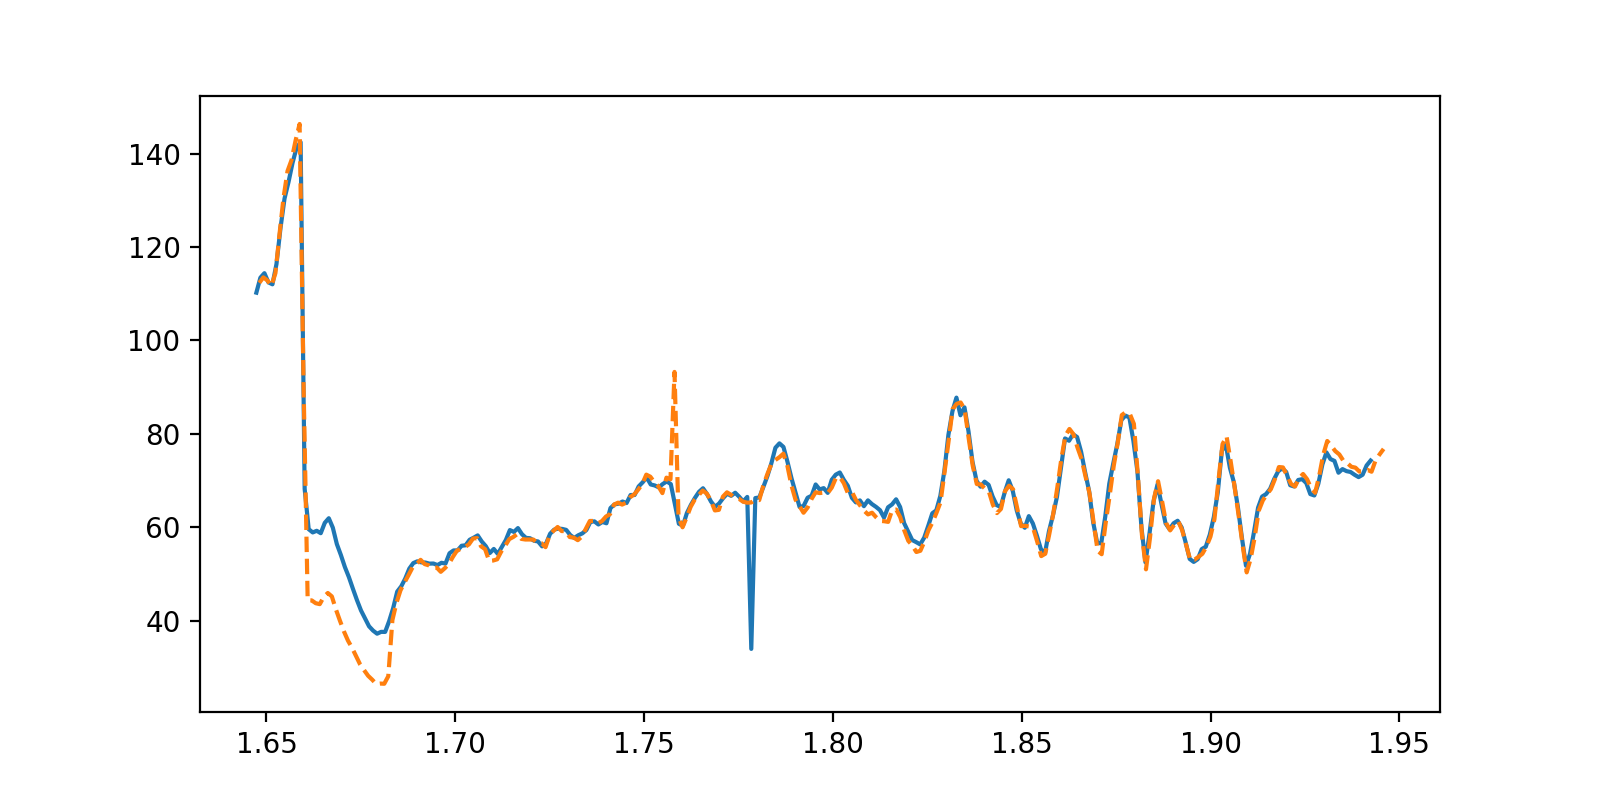

<IPython.core.display.Javascript object>


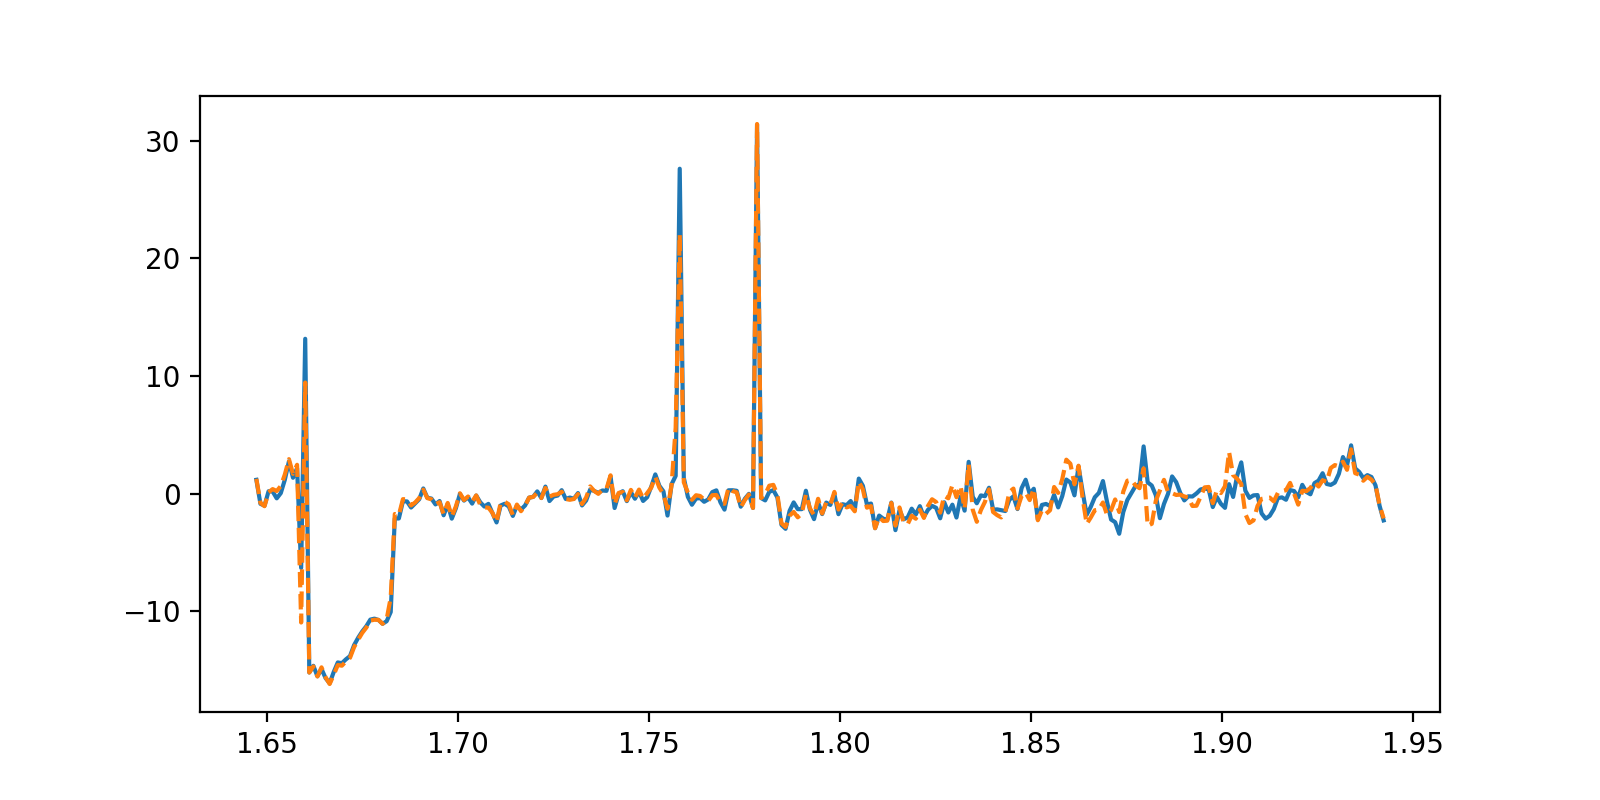

<IPython.core.display.Javascript object>


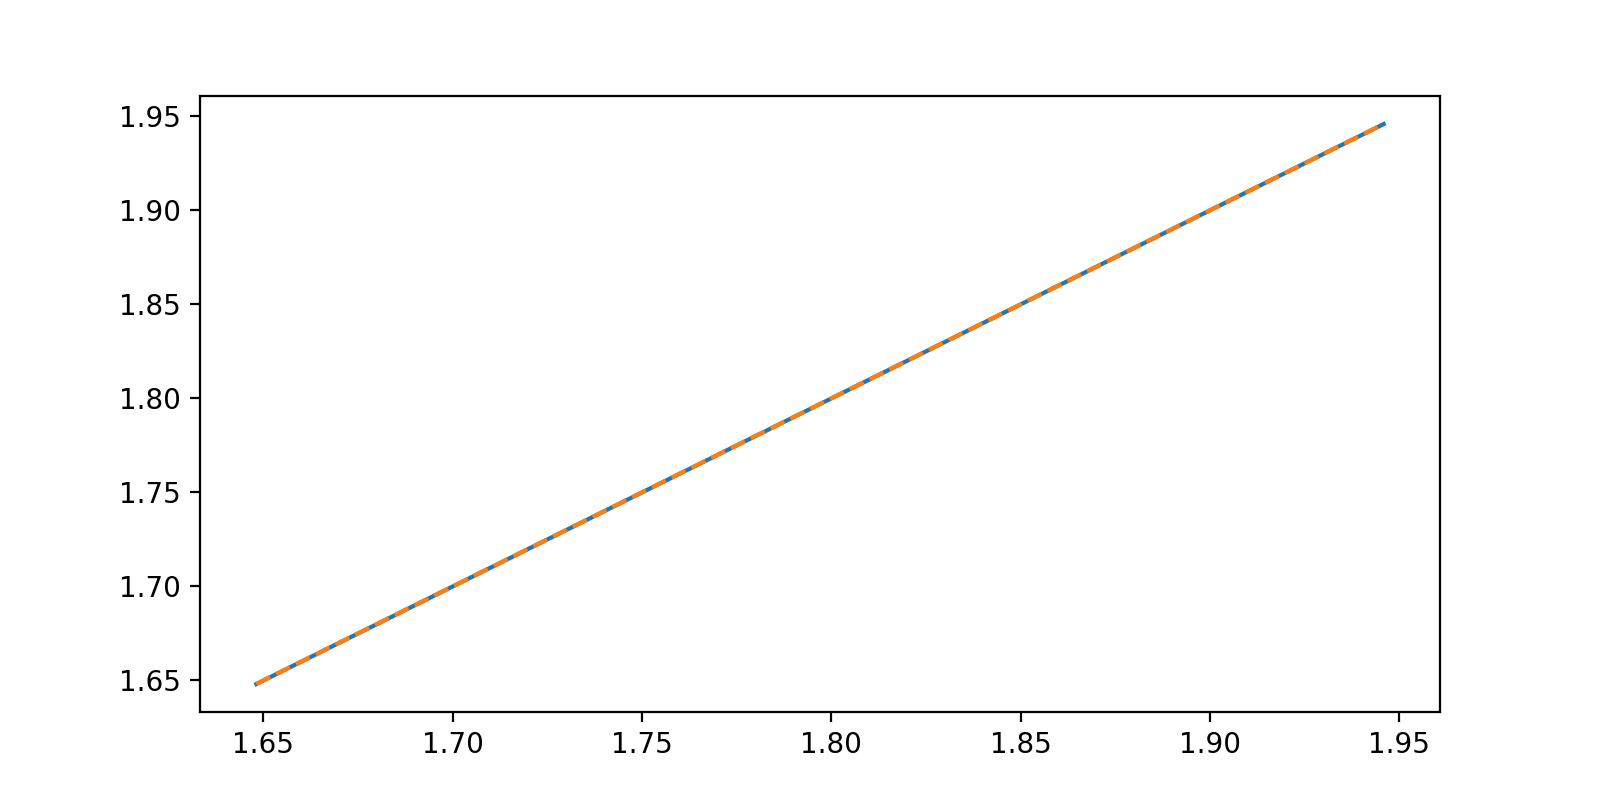

In [48]:
#The result found a scale factor almost exactly 1/1.1
alt_wave2a = alter_wave(pixel_fit2.x, bad_wave2)
alt_spec2a = alter_spec(alt_wave2)

fig9 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, scaled_spec1)
tmp = plt.plot(alt_wave2a, spec2[in_wave2], '--')

fig10 = plt.figure(figsize=(8,4))
tmp = plt.plot(out_wave, interp_spec2 - scaled_spec1)
tmp = plt.plot(out_wave, alt_spec2a - scaled_spec1, '--')

fig11 = plt.figure(figsize=(8,4))
tmp = plt.plot(wave2[in_wave2], alt_wave2a)
tmp = plt.plot(wave2[in_wave2], wave2[in_wave2], '--')

In [50]:
import sys, astropy, numpy, scipy
print('Versions:')
print('  python: ', sys.version_info)
print('  astropy: ', astropy.__version__)
print('  scipy: ', scipy.__version__)
print('  numpy: ', np.__version__)

Versions:
  python:  sys.version_info(major=3, minor=5, micro=6, releaselevel='final', serial=0)
  astropy:  3.1.dev22604
  scipy:  1.1.0
  numpy:  1.15.2
